### Towards Interpretable Hemodynamic Fluctuations of Photoplethysmography with Ranking-based Multi-Instance Learning
- **Salience-induced Interpretability of Deep Neural Network in Healthcare**
- **Ranking-based concept for salience-induced aggregations**
- **Simluation-Model-Driven Hemodynamic States Fluctuation**  

In [1]:
import os
# Navigate to correct directory
print(os.getcwd())
if os.getcwd().endswith("notebooks"):
    os.chdir("../")
print(os.getcwd())
# Setup auto reload of source code changes
%load_ext autoreload
%autoreload 2

/home/danielwang_echo/Documents/IHemoMIL/notebooks
/home/danielwang_echo/Documents/IHemoMIL


In [2]:
import logging 
logger = logging.getLogger("IHEMOMIL.Evaluation-Visualization")

In [3]:
data_path = 'data' # select your data path
checkpoint = 'checkpoint' # select your checkpoint path

channels = 1  # signal channel
d_model = 128  # embedding dimension
d_attn = 8 # attention dimension
apply_positional_encoding = True # apply positional encoding

dropout = 0.1 # dropout rate
p_rank = 0.5  # positive rank
p_alpha = 0.5  # positive alpha

### Datasets and labels profile for the experiments
|   Data Name   |  Input Param | Label Name |
|----------|----------|----------|
|   PRRB   |   mp_ppg_TBME   |   MORPPERTURPPG_CLZ_NAMES   |
|  BIDMC   |   mp_ppg_BIDMC   |   MORPPERTURPPG_CLZ_NAMES   |
|   VitalDB   |   mp_ppg_VitalDB   |   MORPPERTURPPG_CLZ_NAMES   |
|  SimHF-3k(LR)   |   simhf3k_LR   |   PERTUR_CLZ_NAMES   |
|  SimHF-3k(LT)   |   simhf3k_LT   |   PERTUR_CLZ_NAMES   |
|  PulseDB-VitalDB   |   bpf   |   PulseDBBPF_CLZ_NAMES   |
|   PERFormAF   |   mimic_af   |   MIMIC_AF_CLZ_NAMES   |
|  DaLia   |   dalia   |   ACTIVITY_CLZ_NAMES   |
|  WebTraffic   |   web_traffic   |   WEBTRAFFIC_CLZ_NAMES   |


In [4]:
from ihemomil.utils import data_selecter
dataset = 'mp_ppg_TBME'   # input parameter for data_selecter
train_dataset, test_dataset = data_selecter(dataset)
n_classes = train_dataset.n_clz
print("Train Size: {}, Test Size: {}".format(len(train_dataset), len(test_dataset)))
print("Number of classes: {}".format(n_classes))

Train Size: 9600, Test Size: 4800
Number of classes: 10


In [5]:
import torch
from torch import nn
use_gpu = True  # use gpu
gpu_id = 0  # gpu id
if torch.cuda.is_available() and use_gpu:
    device = torch.device("cuda:{}".format(gpu_id))
    print("Using GPU: {}".format(gpu_id))
    print(torch.cuda.get_device_name(gpu_id))
else:
    device = torch.device("cpu")
    print("Using CPU as no GPU available")

Using GPU: 0
NVIDIA A100 80GB PCIe


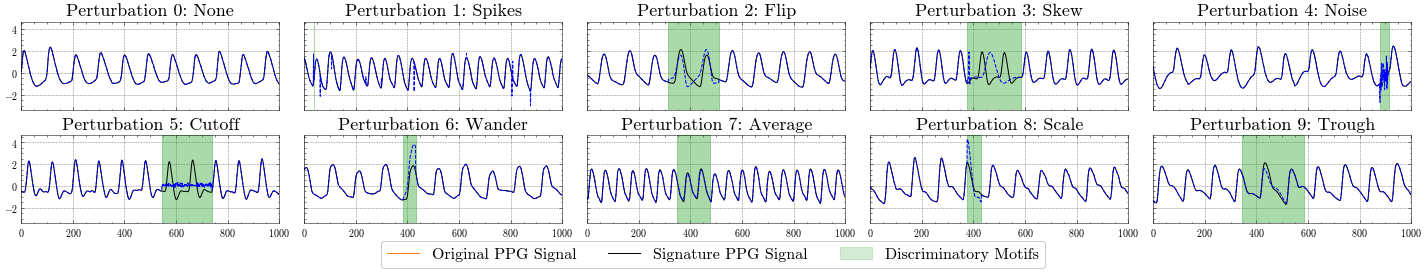

In [6]:
from ihemomil.data.morppertur_ppg_generation import MORPPERTURPPG_CLZ_NAMES
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import scienceplots

colours = plt.rcParams["axes.prop_cycle"].by_key()["color"]
plt.style.use(["science", "ieee", "no-latex", "grid"])

observed_idxs=[]
for clz in range(train_dataset.n_clz):
    idx_clz = train_dataset.get_n_idxs(1, clz=clz, shuffle=True)
    observed_idxs.append(idx_clz)

def plot_misclassified_time_series():
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 4), sharex=True, sharey=True)
    # Plot each "peak as none" example
    for i, idx in enumerate(observed_idxs):
        # Get original and signature time series
        orig_ts = train_dataset.get_bag(idx-i*960)
        sig_ts = train_dataset.get_bag(idx)
        # Plot time series
        axis = axes[i // 5, i % 5]
        axis.plot(orig_ts, color="k")
        axis.plot(sig_ts, color="b")
        # Plot signature location
        if i != 0:
            signature_locations = train_dataset.get_signature_locations(idx)
            axis.axvspan(*signature_locations[0], alpha=0.4, color=colours[2])
        # Configure axis
        axis.set_xlim(0, len(sig_ts))
        axis.set_title("Perturbation {:d}: {:s}".format(i, MORPPERTURPPG_CLZ_NAMES[i].capitalize()), fontsize=18)
    # Custom legend
    handles = [
        Line2D([0], [0], color=colours[1]),
        Line2D([0], [0], color="k"),
        Patch(edgecolor=colours[2], facecolor=colours[2], fill=True, alpha=0.2),
    ]
    fig.legend(
        handles=handles,
        labels=[
            "Original PPG Signal",
            "Signature PPG Signal",
            "Discriminatory Motifs",
        ],
        loc="lower center",
        ncol=3,
        fontsize=16,
    )

plot_misclassified_time_series()
plt.tight_layout()
plt.subplots_adjust(bottom=0.2)
#plt.savefig(os.path.join("visualization-1.png"), dpi=600, bbox_inches='tight', transparent=True)

In [7]:
from ihemomil.model import backbone, pooling
from ihemomil.model.ihemomil_model import IHemoMILModel
from ihemomil.utils import BulidModel, BACKBONE_ZOO, POOLING_METHODS

In [8]:
def model_bulider_and_evaluator(backbone_model='inceptiontime', pooling_method='rap'):
    model_name = f"{backbone_model}_{pooling_method}"
    checkpoint_dir = os.path.join(checkpoint, dataset, model_name)
    backbone_arch = BACKBONE_ZOO.get(backbone_model)
    pooling_med = POOLING_METHODS.get(pooling_method)
    
    pooling_args = {
        'gap': (d_model, n_classes, dropout, p_rank, apply_positional_encoding),
        'rap': (d_model, n_classes, dropout, p_rank, apply_positional_encoding),
        'conj': (d_model, n_classes, d_attn, dropout, apply_positional_encoding),
        'rconj': (d_model, n_classes, d_attn, dropout, apply_positional_encoding),
    }
    
    default_args = (d_model, n_classes, d_attn, dropout, p_alpha, apply_positional_encoding)
    args = pooling_args.get(pooling_method, default_args)
    net = BulidModel(backbone_arch(channels), pooling_med(*args))
    ihemomil = IHemoMILModel("BulidModel", device, n_classes, net)
    return ihemomil, checkpoint_dir

def load_and_evaluate_model(backbone_model, pooling_method):
    model, checkpoint_dir = model_bulider_and_evaluator(backbone_model, pooling_method)
    load_model_path = os.path.join(checkpoint_dir, "model.pth")
    model.load_weights(load_model_path)
    return model

In [9]:
backbone_model = 'inceptiontime'
# Load and evaluate model with 'rap' pooling method
ihemomil_rap = load_and_evaluate_model(backbone_model, 'rap')
ihemomil_gap = load_and_evaluate_model(backbone_model, 'gap')
ihemomil_cop = load_and_evaluate_model(backbone_model, 'conj')
ihemomil_rcop = load_and_evaluate_model(backbone_model, 'rconj')

In [10]:
from ihemomil.utils import results_log
# Evaluate predictive performance on train and test splits
train_results_dict = ihemomil_rap.evaluate(train_dataset)
test_results_dict = ihemomil_rap.evaluate(test_dataset)
# Evaluate interpretability on train and test splits
train_aopcr, train_ndcg = ihemomil_rap.evaluate_interpretability(train_dataset)
test_aopcr, test_ndcg = ihemomil_rap.evaluate_interpretability(test_dataset)
header = ["Split", "Accuracy", "b-accuracy", "AUROC", "Loss", "AOPCR", "NDCG@n"]
train_row = ["Train", train_results_dict["acc"], train_results_dict["bal_acc"], train_results_dict["auroc"],
                 train_results_dict["loss"], train_aopcr, train_ndcg,]
test_row = ["Test", test_results_dict["acc"], test_results_dict["bal_acc"], test_results_dict["auroc"],
                test_results_dict["loss"], test_aopcr, test_ndcg,]
results_data = [header, train_row, test_row]
# Print results table
results_log(results_data)

                                               
+-------+----------+------------+-------+-------+-------+--------+
| Split | Accuracy | b-accuracy | AUROC | Loss  | AOPCR | NDCG@n |
+=======+==========+============+=======+=======+=======+========+
| Train | 0.997    | 0.997      | 1.000 | 0.013 | 6.339 | 0.699  |
+-------+----------+------------+-------+-------+-------+--------+
| Test  | 0.951    | 0.951      | 0.998 | 0.215 | 6.561 | 0.690  |
+-------+----------+------------+-------+-------+-------+--------+


In [11]:
import matplotlib as mpl
import numpy as np

colours = plt.rcParams["axes.prop_cycle"].by_key()["color"]

def plot_single_bg_heatmap(axis, values, cmap, norm, xs=None, alpha=0.8):
    if xs is None:
        xs = range(len(values))
    for x, s in zip(xs, values):
        colour = cmap(norm(s))
        axis.axvspan(x - 0.5, x + 0.5, color=colour, alpha=alpha, lw=0)

def plot_max_bg_heatmap(axis, multi_values, multi_cmap, norm, xs=None, alpha=0.8):
    if xs is None:
        xs = range(multi_values.shape[1])
    maxs = torch.argmax(multi_values, dim=0)
    for x in xs:
        m = maxs[x]
        cmap = multi_cmap[m]
        value = multi_values[m][x]
        colour = cmap(norm(value))
        axis.axvspan(x - 0.5, x + 0.5, color=colour, alpha=alpha, lw=0)

def get_cmap(colour):
    return mpl.colors.LinearSegmentedColormap.from_list("", ["ghostwhite", "white", "blue"])

Label: 3 (Skew)
-- Idx: 1447 --
Class 0 (None): 0.861
Class 3 (Skew): 0.126
mean: -0.291, std: 17.016
-- Idx: 1447 --
Class 0 (None): 0.214
Class 3 (Skew): 0.772
mean: 1.483, std: 3.377
-- Idx: 1447 --
Class 0 (None): 0.001
Class 3 (Skew): 0.999
mean: 2.480, std: 29.528
-- Idx: 1447 --
Class 0 (None): 0.000
Class 3 (Skew): 1.000
mean: 3.927, std: 29.291


<Figure size 432x288 with 0 Axes>

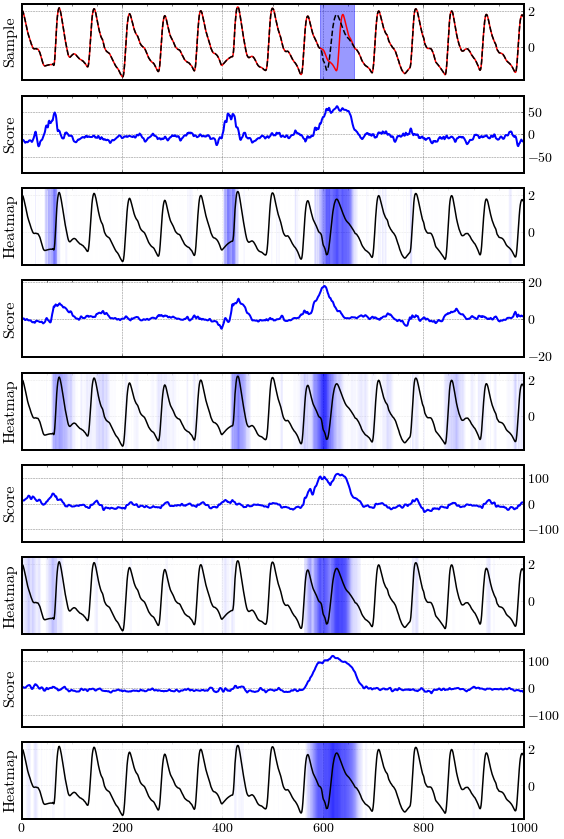

In [12]:
def plot_interpretations(idx, observed_clz, models, colours, test_dataset, MORPPERTURPPG_CLZ_NAMES):
    fig, axes = plt.subplots(nrows=9, ncols=1, sharex=True, figsize=(9, 15))

    orig_ts = test_dataset.get_bag(idx - observed_clz * 480)
    sig_ts = test_dataset.get_bag(idx)
    label = test_dataset.get_target(idx)
    print(f"Label: {label} ({MORPPERTURPPG_CLZ_NAMES[label].capitalize()})")

    # Plot time series
    axes[0].plot(orig_ts, color=colours[1], linewidth=1.5)
    axes[0].plot(sig_ts, color="k", linewidth=1.5)
    signature_locations = test_dataset.get_signature_locations(idx)
    axes[0].axvspan(*signature_locations[0], alpha=0.4, color=colours[2])
    axes[0].set_xlim(0, len(sig_ts))

    def plot_model_interpretation(model, axis_score, axis_heatmap):
        bag = test_dataset[idx]["bag"]
        model_out = model(bag)
        bag_logits = model_out["bag_logits"]
        bag_probas = torch.softmax(bag_logits, dim=0)
        print(f"-- Idx: {idx} --")
        for c in [0, observed_clz]:
            print(f"Class {c} ({MORPPERTURPPG_CLZ_NAMES[c].capitalize()}): {bag_probas[c]:.3f}")
        clz_interpretations = model.interpret(model_out).detach().cpu()
        average_interpretation = clz_interpretations[observed_clz]
        lim = max(max(abs(clz_interpretations[0])), max(abs(average_interpretation)))
        print(f"mean: {torch.mean(average_interpretation):.3f}, std: {torch.std(average_interpretation):.3f}")
        axis_score.plot(average_interpretation, color=colours[2], linewidth=2)
        axis_score.set_ylim(-int(lim * 1.2), int(lim * 1.2))
        norm = plt.Normalize(-lim, lim)
        axis_heatmap.plot(sig_ts, color="k", linewidth=1.5)
        plot_single_bg_heatmap(axis_heatmap, average_interpretation, get_cmap(colours[2]), norm)

    for i, model in enumerate(models):
        plot_model_interpretation(model, axes[2 * i + 1], axes[2 * i + 2])

    for axis in axes:
        axis.yaxis.tick_right()
        axis.tick_params(axis='x', labelsize=14)
        axis.tick_params(axis='y', labelsize=14)
        axis.spines["top"].set_linewidth(2.0)
        axis.spines["right"].set_linewidth(2.0)
        axis.spines["bottom"].set_linewidth(2.0)
        axis.spines["left"].set_linewidth(2.0)

    axes[0].set_ylabel("Sample", fontsize=16, fontweight="bold")
    for i in range(1, 9, 2):
        axes[i].set_ylabel("Score", fontsize=16, fontweight="bold")
        axes[i + 1].set_ylabel("Heatmap", fontsize=16, fontweight="bold")

# Example usage
plt.tight_layout()
plot_interpretations(idx=1447, observed_clz=3, models=[ihemomil_gap, ihemomil_rap, ihemomil_cop, ihemomil_rcop], 
                     colours=colours, test_dataset=test_dataset, MORPPERTURPPG_CLZ_NAMES=MORPPERTURPPG_CLZ_NAMES)


In [13]:
from tqdm import tqdm
def get_features_and_labels(ihemomil, dataset):
    features = []
    labels = []
    bag_embeddings = []
    for item in tqdm(range(len(dataset))):
        bag = dataset[item]["bag"]
        label = dataset[item]["target"]
        labels.append(label)
        output = ihemomil(bag)
        features.append(output["feature"].cpu().detach().numpy())
        bag_embeddings.append(output["bag_embeddings"].cpu().detach().numpy())
    features = np.array(features)
    labels = np.array(labels)
    bag_embeddings = np.array(bag_embeddings)
    return features, labels, bag_embeddings

100%|██████████| 4800/4800 [00:36<00:00, 132.49it/s]


t-SNE: 4.39 s


100%|██████████| 4800/4800 [00:36<00:00, 131.70it/s]


t-SNE: 4.23 s


100%|██████████| 4800/4800 [00:35<00:00, 134.91it/s]


t-SNE: 4.24 s


100%|██████████| 4800/4800 [00:35<00:00, 134.67it/s]


t-SNE: 4.35 s


<ipython-input-14-c1eaf815049b>:37: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter([], [], c=plt.cm.Spectral(j / len(unique_labels)), label=label.capitalize())
<ipython-input-14-c1eaf815049b>:40: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


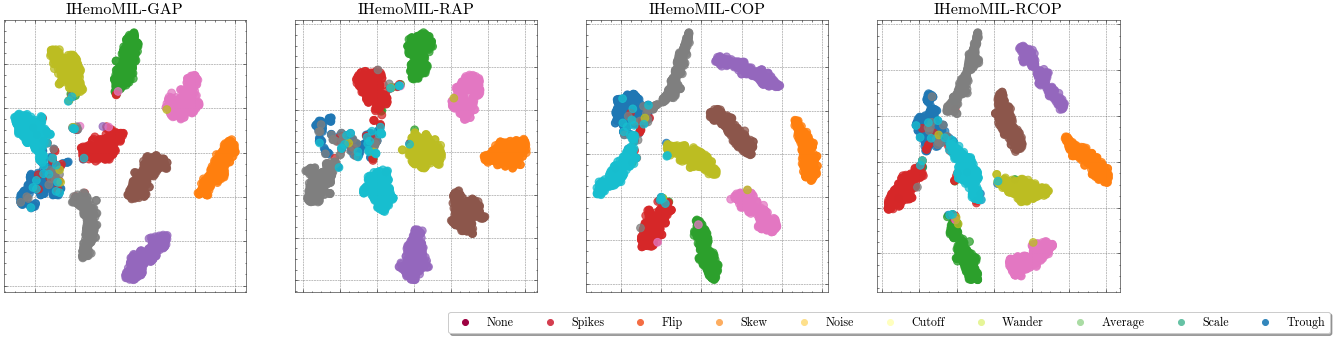

In [14]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
from time import time

def get_features_and_plot_tsne(models, perplexities=30):
    fig, axes = plt.subplots(nrows=1, ncols=len(models), figsize=(20, 5))
    mode_names = ["IHemoMIL-GAP", "IHemoMIL-RAP", "IHemoMIL-COP", "IHemoMIL-RCOP"]
    for i, model in enumerate(models):
        _, labels, bag_embeddings = get_features_and_labels(model, test_dataset)
    
        tsne_features = []
        tsne_labels = []
        

        for label in range(n_classes):
            indices = np.where(labels == label)[0][:240]
            tsne_features.append(bag_embeddings[indices])
            tsne_labels.append(labels[indices])
        tsne_features = np.concatenate(tsne_features, axis=0)
        tsne_labels = np.concatenate(tsne_labels, axis=0)   
        tsne = TSNE(n_components=2, init='pca', perplexity=perplexities, random_state=42)
        
        t0 = time()
        X_tsne = tsne.fit_transform(tsne_features)
        t1 = time()
        print(f"t-SNE: {t1 - t0:.2f} s")
        
        ax = axes[i]
        ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=tsne_labels, cmap='tab10', s=60, alpha=0.75)
        ax.xaxis.set_major_formatter(plt.NullFormatter())
        ax.yaxis.set_major_formatter(plt.NullFormatter())
        ax.axis('tight')
        ax.set_title(f"{mode_names[i]}", fontsize=16)
    unique_labels = np.unique(labels)
    for j, label in zip(unique_labels, MORPPERTURPPG_CLZ_NAMES):
        plt.scatter([], [], c=plt.cm.Spectral(j / len(unique_labels)), label=label.capitalize())
    
    plt.legend(loc='upper center', bbox_to_anchor=(0.05, -0.05), fancybox=True, shadow=True, ncol=len(unique_labels), prop={'size': 12})
    plt.tight_layout()
get_features_and_plot_tsne([ihemomil_gap, ihemomil_rap, ihemomil_cop, ihemomil_rcop], perplexities=30)

Copyright: Copyright (c) 2024. All rights reserved.

- Author: Daniel Wang@Fudan University
- Date: 2024-07-17
- Purpose: This notebook is used for visualizing data.
- Background: This notebook was created as part of a project to improve data visualization.